In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, string, nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
from nltk.tokenize import TweetTokenizer

In [24]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Embedding, GRU, Input, Bidirectional
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.utils import np_utils

In [2]:
pd.set_option('max_colwidth', 800)


In [3]:
test_data = pd.read_csv('..\..\data\hateval2019_en_test.csv')
train_data = pd.read_csv('..\..\data\hateval2019_en_train.csv')
dev_data = pd.read_csv('..\..\data\hateval2019_en_dev.csv')

In [4]:
print(test_data.shape), print(train_data.shape), print(dev_data.shape)

(3000, 5)
(9000, 5)
(1000, 5)


(None, None, None)

In [5]:
data = pd.concat([train_data, dev_data, test_data])

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      13000 non-null  int64 
 1   text    13000 non-null  object
 2   HS      13000 non-null  int64 
 3   TR      13000 non-null  int64 
 4   AG      13000 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 609.4+ KB


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      13000 non-null  int64 
 1   text    13000 non-null  object
 2   HS      13000 non-null  int64 
 3   TR      13000 non-null  int64 
 4   AG      13000 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 609.4+ KB


In [8]:
data[['id','TR','AG']].value_counts()

id     TR  AG
201    0   0     1
8871   1   1     1
8861   0   0     1
8862   1   1     1
8863   1   1     1
                ..
4537   0   0     1
4538   0   0     1
4539   0   1     1
4540   0   0     1
34597  0   0     1
Length: 13000, dtype: int64

In [9]:
data.drop(['id','TR','AG'], axis=1, inplace=True)

In [10]:
x_train, x_pred, y_train, y_pred = train_test_split(data['text'], data['HS'], test_size=0.2, random_state=42)

<AxesSubplot:title={'center':'Training Data'}>

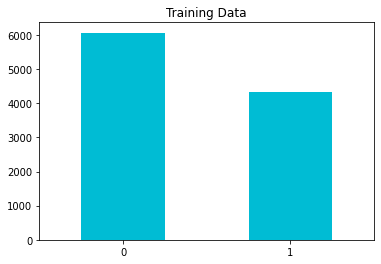

In [11]:
y_train.value_counts().plot(kind='bar',
 title='Training Data', 
 color='#00bcd4',
 x='labels',
 y='count',
 rot=0,
)

# Preprocessing 

In [12]:
def clean_text(text):
    print(text)
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    twtk = TweetTokenizer(strip_handles=True, reduce_len=True)
    text = " ".join([w for w in twtk.tokenize(text) if w != "" and w is not None])
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)

    return text

In [13]:
def removeStopwords(tokens):
    stops = set(stopwords.words("english"))
    stops.update(['.',',','"',"'",'?',':',';','(',')','[',']','{','}'])
    toks = [tok for tok in tokens if not tok in stops and len(tok) >= 3]
    return toks

def removeURL(text):
    newText = re.sub('http\\S+', '', text, flags=re.MULTILINE)
    return str(newText)

def removeNum(text):
    newText = re.sub('\\d+', '', text)
    return newText

def removeHashtags(tokens):
    toks = [ tok for tok in tokens if tok[0] != '#']
#     if segment == True:
#         segTool = Analyzer('en')
#         for i, tag in enumerate(self.hashtags):
#             text = tag.lstrip('#')
#             segmented = segTool.segment(text)

    return toks

def stemTweet(tokens):
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in tokens]
    return stemmed_words

In [14]:
def processTweet(tweet, remove_swords = True, remove_url = True, remove_hashtags = True, remove_num = True, stem_tweet = True):
#     text = tweet.translate(string.punctuation)   -> to figure out what it does ?
    """
        Tokenize the tweet text using TweetTokenizer.
        set strip_handles = True to Twitter username handles.
        set reduce_len = True to replace repeated character sequences of length 3 or greater with sequences of length 3.
    """
    if remove_url:
        tweet = removeURL(tweet)
    twtk = TweetTokenizer(strip_handles=True, reduce_len=True)
    tokens = [w.lower() for w in twtk.tokenize(str(tweet)) if w != "" and w is not None]
    if remove_hashtags:
        tokens = removeHashtags(tokens)
    if remove_swords:
        tokens = removeStopwords(tokens)
    if stem_tweet:
        tokens = stemTweet(tokens)
    text = " ".join(tokens)
    return text

In [15]:
data["text"] = data.apply(lambda x: processTweet(x['text'], remove_url=True), axis=1)

In [16]:
data.head()

,text,HS
0,hurray save mani way,1
1,would young fight age men vast major one escap war cannot fight like women children elder major refuge actual refuge econom migrant tri get europ ...,1
2,illeg dump kid border like road kill refus unit hope get amnesti free educ welfar illeg countri taxpay dime scam,1
3,time near white state pose array problem immigr,0
4,orban brussel european leader ignor peopl want migrant,0


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    13000 non-null  object
 1   HS      13000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 304.7+ KB


# Word Embedding Model

In [34]:
# tweets = train_data['text']
maxlen = 140
data['text'] = data['text'].map(lambda x: processTweet(x))
vocabulary_size = 30000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(data['text'])
X_train = tokenizer.texts_to_sequences(data['text'])
# print(sequences)
X_train = pad_sequences(X_train, maxlen=maxlen)
labels = data['HS']
Y_train = np_utils.to_categorical(labels, len(set(labels)))
V = len(tokenizer.word_index) + 1


l2_coef = 0.001


tweet = Input(shape=(maxlen,), dtype='int32')
model = Sequential()
model.add(Embedding(V, 128, input_length=maxlen, kernel_regularizer =l2(l=l2_coef)))
model.add(Dropout(0.2))
model.add(Bidirectional(layer=GRU(128, return_sequences=False, 
                            kernel_regularizer =l2(l=l2_coef),
                            b_regularizer=l2(l=l2_coef),
                            U_regularizer=l2(l=l2_coef)),
                  merge_mode='sum'))
model.add(Dropout(0.2))
model.add(Dense(len(set(labels)), kernel_regularizer =l2(l=l2_coef), activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()






# x = Embedding(V, 128, input_length=maxlen, kernel_regularizer =l2(l=l2_coef))(tweet)
# x = Bidirectional(layer=GRU(128, return_sequences=False, 
#                             kernel_regularizer =l2(l=l2_coef),
#                             b_regularizer=l2(l=l2_coef),
#                             U_regularizer=l2(l=l2_coef)),
#                   merge_mode='sum')(x)
# x = Dense(len(set(labels)), kernel_regularizer =l2(l=l2_coef), activation="softmax")(x)

# tweet2vec = Model(input=tweet, output=x)

# tweet2vec.compile(loss='categorical_crossentropy',
#                   optimizer='RMSprop',
#                   metrics=['accuracy'])


# tweet2vec.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.1)


TypeError: ('Keyword argument not understood:', 'kernel_regularizer')